# Packages

In [33]:
!pip install dataretrieval

In [34]:
import dataretrieval.nwis as nwis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import requests
from datetime import datetime, timezone, timedelta

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

# Data Loading

In [37]:
start_date = '1994-02-26'
end_date = '2024-06-20'

In [38]:
# Get Arkansas river flow data from Parkdale and reformat
parkdale = nwis.get_record(sites='07094500', service='iv', start = start_date, end = end_date)
parkdale.index = parkdale.index.tz_convert(tz='America/Denver')
parkdale.reset_index(inplace=True)
parkdale['datetime'] = pd.to_datetime(parkdale['datetime'])
parkdale = parkdale[['datetime', '00060']]

parkdale.set_index('datetime', inplace=True)
parkdale = parkdale.resample('D').max().dropna()
parkdale.index = parkdale.index.strftime("%Y-%m-%d")
parkdale.index = pd.to_datetime(parkdale.index)

In [39]:
# Get discharge data from upstream Twin Lakes reservoir and reformat
twin_link = 'https://dwr.state.co.us/Tools/Stations/ExportObsTsFileResult?abbrevs=LAKBTLCO&parameters=DISCHRG&por_start=' + start_date + 'T07%3A00%3A00.000Z&toDate=' + end_date + 'T05%3A59%3A59.000Z&timeStep=' + start_date + 'T07%3A00%3A00.000Z&por_end=' + end_date + 'T05%3A59%3A59.000Z&time_step=DailyAverage&obs_type=best&avg_time=12%3A00%20AM&is_x_tab=true'
twin = pd.read_csv(twin_link)

twin = twin[['Date Time', 'DISCHRG Value']]
twin.rename(columns={'DISCHRG Value':'DISCHRG'}, inplace=True)
twin['Date Time'] = [date_time.split(" ")[0] for date_time in twin['Date Time']]
twin['Date Time'] = twin['Date Time'].apply(lambda x: x.replace('=', '').replace('"', ''))
twin['Date Time'] = pd.to_datetime(twin['Date Time'])
twin.set_index('Date Time', inplace=True)

In [40]:
# Get discharge data from upstream Turquoise reservoir and reformat
turq_link = 'https://dwr.state.co.us/Tools/Stations/ExportObsTsFileResult?abbrevs=LFCBSLCO&parameters=DISCHRG&por_start=' + start_date + 'T07%3A00%3A00.000Z&toDate=' + end_date + 'T05%3A59%3A59.000Z&timeStep=' + start_date + 'T07%3A00%3A00.000Z&por_end=' + end_date + 'T05%3A59%3A59.000Z&time_step=DailyAverage&obs_type=best&avg_time=12%3A00%20AM&is_x_tab=true'
turq = pd.read_csv(turq_link)

turq = turq[['Date Time', 'DISCHRG Value']]
turq.rename(columns={'DISCHRG Value':'DISCHRG'}, inplace=True)
turq['Date Time'] = [date_time.split(" ")[0] for date_time in turq['Date Time']]
turq['Date Time'] = turq['Date Time'].apply(lambda x: x.replace('=', '').replace('"', ''))
turq['Date Time'] = pd.to_datetime(turq['Date Time'])
turq.set_index('Date Time', inplace=True)

In [41]:
# Combine Twin Lakes and Turquoise data to get combined upstream reservoir discharge
res = twin.add(turq)

In [42]:
# Reformats NWCC basin data so that it's in actual years and not water years. Melts all data into one column.
def format_data(data):

  data = data.iloc[:, :data.columns.get_loc('2024') + 1]
  data['2024'].fillna(0, inplace=True)

  data['date'].fillna('02-29', inplace=True)

  # Create a new '1991' column and insert it as the second column
  data.insert(1, '1991', None)

  data.set_index('date', inplace=True)

  # Shift October - December data to the left
  mask = (data.index >= '10-01') & (data.index <= '12-31')
  data.iloc[mask, :-1] = data.iloc[mask, 1:].values

  # Sort and reset dates
  data.sort_index(inplace=True)
  data.reset_index(inplace=True)

  # Melt data into 1 column
  data = pd.melt(data, id_vars=['date'], var_name='year', value_name='value')
  data['datetime'] = data['date'] + '-' + data['year']
  data = data.drop(['date', 'year'], axis=1)
  data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
  data = data.dropna()
  data.set_index('datetime', inplace=True)
  data = data[start_date:end_date]
  return data

In [43]:
# Snowpack data for Arkansas river basin.
snowpack = pd.read_csv("https://nwcc-apps.sc.egov.usda.gov/awdb/basin-plots/POR/WTEQ/assocHUC6/110200_Upper_Arkansas.csv")

snowpack = format_data(snowpack)
snowpack.rename(columns={'value':'snow'}, inplace=True)

In [44]:
# Combines datasets together into one dataframe
combined = parkdale.join(snowpack, how='outer')
combined = combined.join(res, how='outer')
combined['00060'].fillna(method='ffill', inplace=True)
combined['DISCHRG'].fillna(method='ffill', inplace=True)

In [45]:
combined

,00060,snow,DISCHRG
1994-02-26,564.0,10.083333,251.1
1994-02-27,558.0,10.116667,250.1
1994-02-28,546.0,10.166667,253.1
1994-03-01,546.0,10.383333,255.1
1994-03-02,546.0,10.416667,246.1
...,...,...,...
2024-06-16,4230.0,0.714286,999.0
2024-06-17,3890.0,0.72,900.0
2024-06-18,3680.0,0.48,844.0
2024-06-19,3390.0,0.188889,783.0


# Plots

In [46]:
def dataplots(start, end, col, title, yax):
    section = combined[(combined.index >= start) & (combined.index <= end)].copy()

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(section.index, section[col])
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(yax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.tight_layout()
    plt.show()

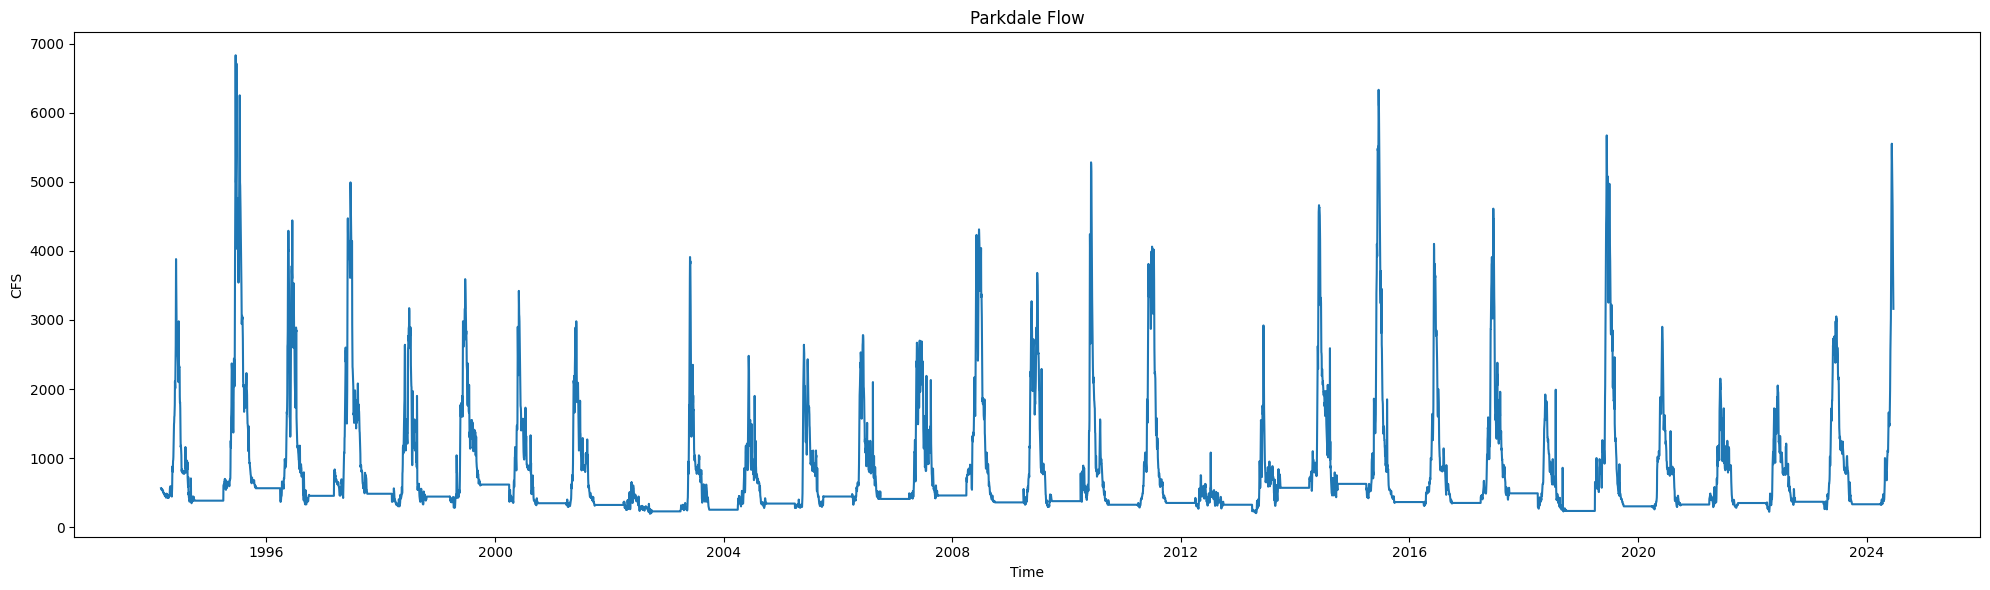

In [47]:
dataplots(start_date, end_date, '00060', 'Parkdale Flow', 'CFS')

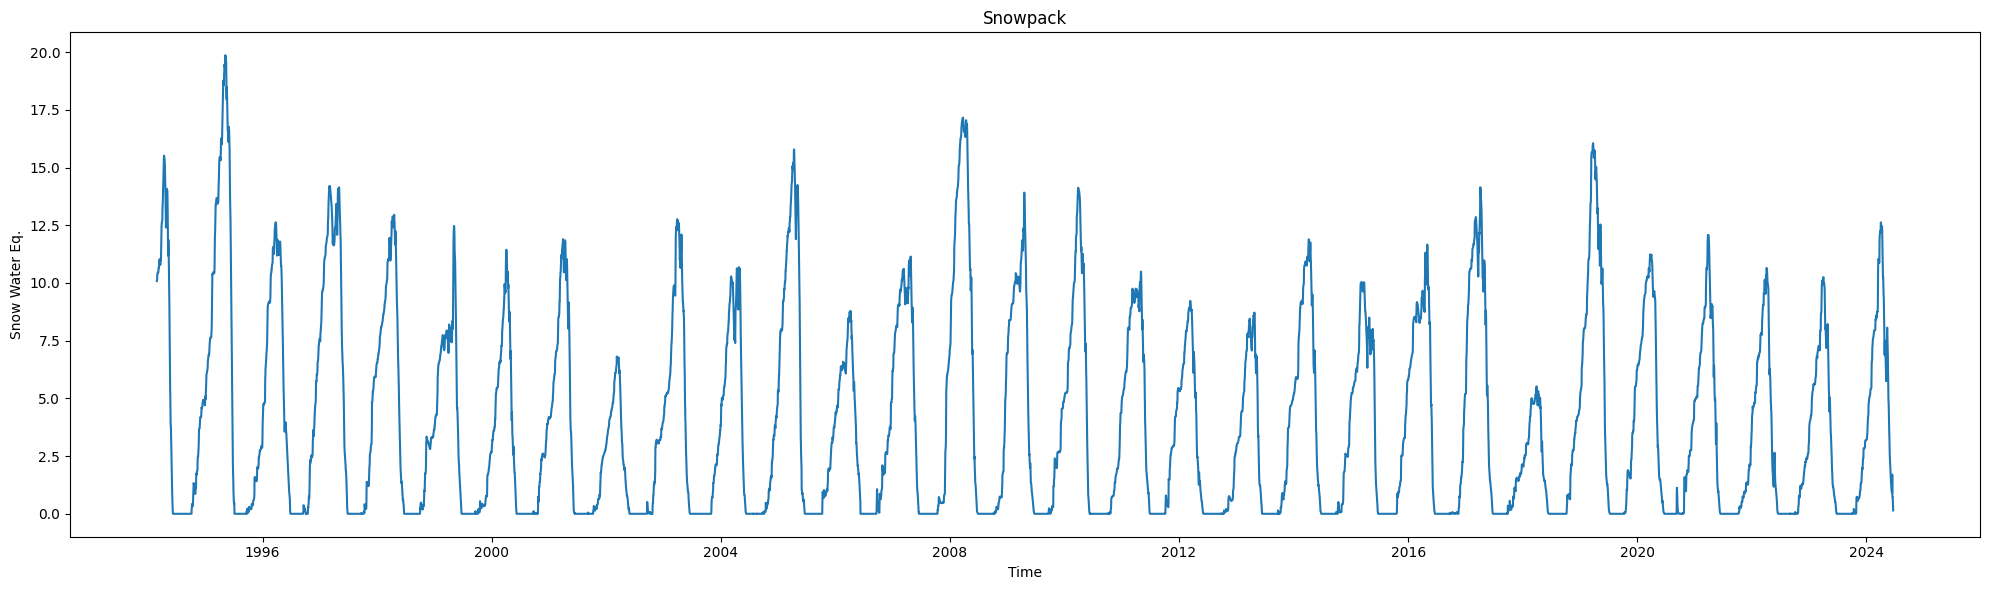

In [48]:
dataplots(start_date, end_date, 'snow', 'Snowpack', 'Snow Water Eq.')

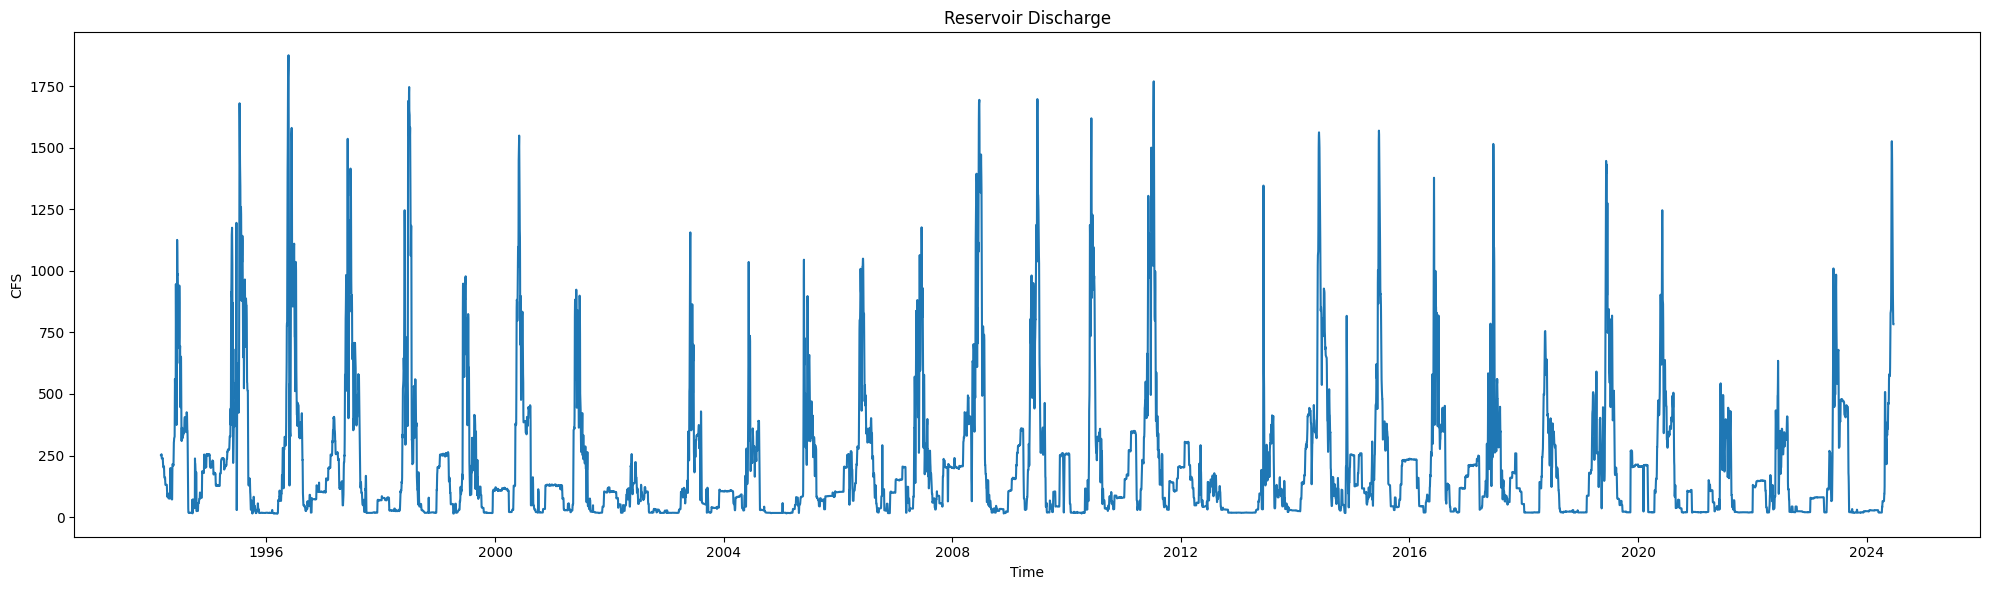

In [49]:
dataplots(start_date, end_date, 'DISCHRG', 'Reservoir Discharge', 'CFS')

# LSTM

### Preprocessing

In [55]:
# Adds sin and cos columns to annual temporal information
combined['Seconds'] = combined.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
combined['Year sin'] = np.sin(combined['Seconds'] * (2 * np.pi / year))
combined['Year cos'] = np.cos(combined['Seconds'] * (2 * np.pi / year))
combined = combined.drop('Seconds', axis=1)
combined

,00060,snow,DISCHRG,Year sin,Year cos
1994-02-26,564.0,10.083333,251.1,0.822875,0.568223
1994-02-27,558.0,10.116667,250.1,0.832528,0.553984
1994-02-28,546.0,10.166667,253.1,0.841934,0.539580
1994-03-01,546.0,10.383333,255.1,0.851091,0.525018
1994-03-02,546.0,10.416667,246.1,0.859997,0.510300
...,...,...,...,...,...
2024-06-16,4230.0,0.714286,999.0,0.267081,-0.963674
2024-06-17,3890.0,0.72,900.0,0.250465,-0.968126
2024-06-18,3680.0,0.48,844.0,0.233774,-0.972291
2024-06-19,3390.0,0.188889,783.0,0.217014,-0.976168


In [56]:
# Split data into X and y
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2]]
    y.append(label)
  return np.array(X), np.array(y)

In [57]:
WINDOW_SIZE = 21
X, y = df_to_X_y(combined, WINDOW_SIZE)
X.shape, y.shape

((11052, 21, 5), (11052, 3))

In [58]:
# Split data into training, validation, and testing sets
train_ind = int(len(X)*0.70)
val_ind = int(train_ind + (len(X)*0.15))

X_train, y_train = X[:train_ind], y[:train_ind]
X_val, y_val = X[train_ind:val_ind], y[train_ind:val_ind]
X_test, y_test = X[val_ind:], y[val_ind:]

# Get mean and standard deviation from just training set
flow_training_mean = np.mean(X_train[:, :, 0])
flow_training_std = np.std(X_train[:, :, 0])

snow_training_mean = np.mean(X_train[:, :, 1])
snow_training_std = np.std(X_train[:, :, 1])

res_training_mean = np.mean(X_train[:, :, 2])
res_training_std = np.std(X_train[:, :, 2])

# Normalize data
def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0] - flow_training_mean) / flow_training_std
  X[:, :, 1] = (X[:, :, 1] - snow_training_mean) / snow_training_std
  X[:, :, 2] = (X[:, :, 2] - res_training_mean) / res_training_std

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - flow_training_mean) / flow_training_std
  y[:, 1] = (y[:, 1] - snow_training_mean) / snow_training_std
  y[:, 2] = (y[:, 2] - res_training_mean) / res_training_std
  return y

preprocess3(X_train)
preprocess3(X_val)
preprocess3(X_test)

preprocess_output3(y_train)
preprocess_output3(y_val)
preprocess_output3(y_test)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [59]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7736, 21, 5), (1657, 21, 5), (1659, 21, 5), (7736, 3), (1657, 3), (1659, 3))

### Training

In [60]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 5)))
model1.add(LSTM(32))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(3, activation='linear'))
cp2 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss='mse', optimizer=RMSprop(learning_rate=0.001), metrics=RootMeanSquaredError())
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 5155 (20.14 KB)
Trainable params: 5155 (20.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

Epoch 1/10
242/242 [==============================] - 10s 32ms/step - loss: 0.2621 - root_mean_squared_error: 0.5119 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3134
Epoch 2/10
242/242 [==============================] - 8s 31ms/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866
Epoch 3/10
242/242 [==============================] - 6s 26ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1765
Epoch 4/10
242/242 [==============================] - 8s 31ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 5/10
242/242 [==============================] - 3s 11ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1402
Epoch 6/10
242/242 [==============================] - 7s 31ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0155

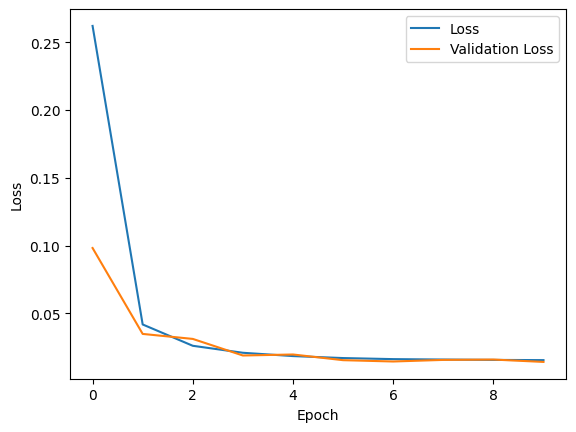

In [62]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Postprocessing

In [63]:
# Inverse normalize data
def postprocess_flow(arr):
  arr = (arr*flow_training_std) + flow_training_mean
  return arr

def postprocess_snow(arr):
  arr = (arr*snow_training_std) + snow_training_mean
  return arr

def postprocess_res(arr):
  arr = (arr*res_training_std) + res_training_mean
  return arr

# Put predicted and actual data into dataframe
def predictions(model, X, y):
  predictions = model.predict(X)
  flow_preds, snow_preds, res_preds = postprocess_flow(predictions[:, 0]), postprocess_snow(predictions[:, 1]), postprocess_res(predictions[:, 2])
  flow_actuals, snow_actuals, res_actuals = postprocess_flow(y[:, 0]), postprocess_snow(y[:, 1]), postprocess_res(y[:, 2])
  df = pd.DataFrame(data={'Flow Predictions': flow_preds,
                          'Flow Actuals': flow_actuals,
                          'Snow Predictions': snow_preds,
                          'Snow Actuals':snow_actuals,
                          'Res Predictions': res_preds,
                          'Res Actuals':res_actuals
                          })
  return df

In [64]:
post_processed_df = predictions(model1, X_test, y_test)
post_processed_df.index = pd.to_datetime(post_processed_df.index, unit='D', origin=pd.Timestamp('2019-12-04'))

52/52 [==============================] - 1s 5ms/step


In [65]:
post_processed_df

,Flow Predictions,Flow Actuals,Snow Predictions,Snow Actuals,Res Predictions,Res Actuals
2019-12-04,319.152191,302.0,3.697094,3.600000,196.316803,205.100006
2019-12-05,318.303802,302.0,3.724213,3.590909,196.647430,205.100006
2019-12-06,318.301392,302.0,3.724511,3.618182,196.822052,205.100006
2019-12-07,317.779602,302.0,3.732958,4.036364,197.103165,205.410004
2019-12-08,311.499207,302.0,3.962730,4.009091,198.235107,205.699997
...,...,...,...,...,...,...
2024-06-14,4376.755371,4230.0,0.764334,0.714286,1015.031616,999.000000
2024-06-15,3985.311523,3890.0,0.502364,0.720000,955.375732,900.000000
2024-06-16,3590.771484,3680.0,0.499830,0.480000,813.936035,844.000000
2024-06-17,3479.270020,3390.0,0.342238,0.188889,845.138428,783.000000


### Test Set Results

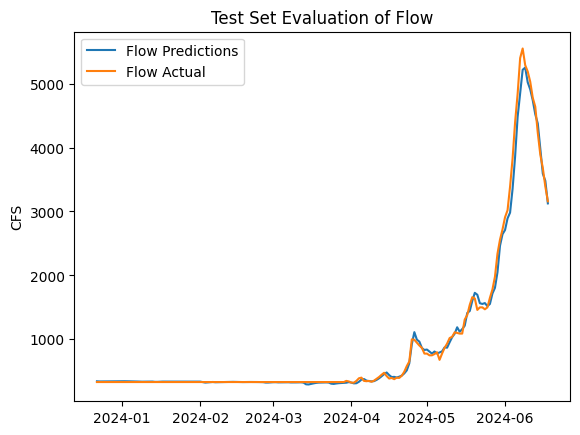

In [66]:
start, end = len(post_processed_df)-180, len(post_processed_df)

plt.plot(post_processed_df['Flow Predictions'][start:end], label='Flow Predictions')
plt.plot(post_processed_df['Flow Actuals'][start:end], label='Flow Actual')
plt.title('Test Set Evaluation of Flow')
plt.ylabel('CFS')
plt.legend()

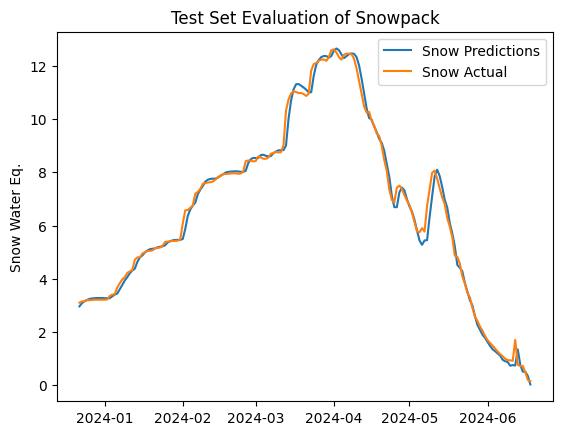

In [67]:
plt.plot(post_processed_df['Snow Predictions'][start:end], label='Snow Predictions')
plt.plot(post_processed_df['Snow Actuals'][start:end], label='Snow Actual')
plt.title('Test Set Evaluation of Snowpack')
plt.ylabel('Snow Water Eq.')
plt.legend()

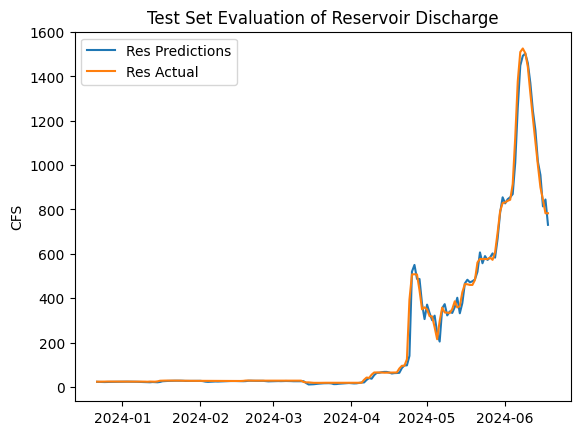

In [68]:
plt.plot(post_processed_df['Res Predictions'][start:end], label='Res Predictions')
plt.plot(post_processed_df['Res Actuals'][start:end], label='Res Actual')
plt.title('Test Set Evaluation of Reservoir Discharge')
plt.ylabel('CFS')
plt.legend()

### Forecasting

In [69]:
# Calculate yearly sin and cos values n days into the future
n_steps = 7
seconds_ = np.array([])
seconds = combined.index[-1].timestamp()
for i in range(n_steps):
    seconds = seconds + 60*60*24
    seconds_ = np.append(seconds_, seconds)

year = 365.2425 * 24 * 60 * 60
day_sin = np.sin(seconds_ * (2 * np.pi / year))
day_cos = np.cos(seconds_ * (2 * np.pi / year))

In [70]:
def forecast(model, data, window_size, n_steps):
  forecasted_flow = np.zeros(n_steps)
  forecasted_snow = np.zeros(n_steps)
  forecasted_res = np.zeros(n_steps)

  data = data[-window_size:]

  for i in range(n_steps):
    # Predict the next values
    predictions = model.predict(data)
    next_flow = predictions[0, 0]
    next_snow = predictions[0, 1]
    next_res = predictions[0, 2]

    # Append the predictions to the forecasted lists
    forecasted_flow[i] = next_flow
    forecasted_snow[i] = next_snow
    forecasted_res[i] = next_res


    # Prepare the next input data
    next_input = np.array([[next_flow, next_snow, next_res, day_sin[i], day_cos[i]]])

    # Append the new input to the current data and slide the window
    data = np.concatenate([data[:, 1:, :], next_input.reshape(1, 1, 5)], axis=1)

  return forecasted_flow, forecasted_snow, forecasted_res

In [71]:
# Get last window of X_test
current_data = X_test[-1]
current_data = current_data.reshape(1, WINDOW_SIZE, 5)

# Add latest day to data
last_day = np.append(y_test[-1], [combined.iloc[-1]['Year sin'], combined.iloc[-1]['Year cos']])
last_window = np.concatenate([current_data[:, 1:, :], last_day.reshape(1, 1, 5)], axis=1)

# Forecast the next n_steps values
forecasted_values = forecast(model1, last_window, WINDOW_SIZE, n_steps)

print("Forecasted flow:", postprocess_flow(forecasted_values[0]))
print("Forecasted snow:", postprocess_snow(forecasted_values[1]))
print("Forecasted snow:", postprocess_res(forecasted_values[2]))

# Get dates for forcasted values
forecast_start = post_processed_df.index[-1] + timedelta(days=1)
forecast_end = forecast_start + timedelta(days=n_steps-1)
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='D')

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame({
    'Flow Predicted': postprocess_flow(forecasted_values[0]),
    'Snow Predicted': postprocess_snow(forecasted_values[1]),
    'Res Predicted': postprocess_res(forecasted_values[2])
}, index=forecast_index)

1/1 [==============================] - 0s 25ms/step
Forecasted flow: [3007.36863002 2881.91159429 2744.03112361 2603.65070788 2468.80607038
 2343.14392333 2227.51552512]
Forecasted snow: [ 0.01693829 -0.10035562 -0.18651944 -0.26361902 -0.33203277 -0.38842031
 -0.43089903]
Forecasted snow: [822.29695605 832.31115177 823.61858645 808.90490335 792.37575268
 775.30107796 757.48819167]


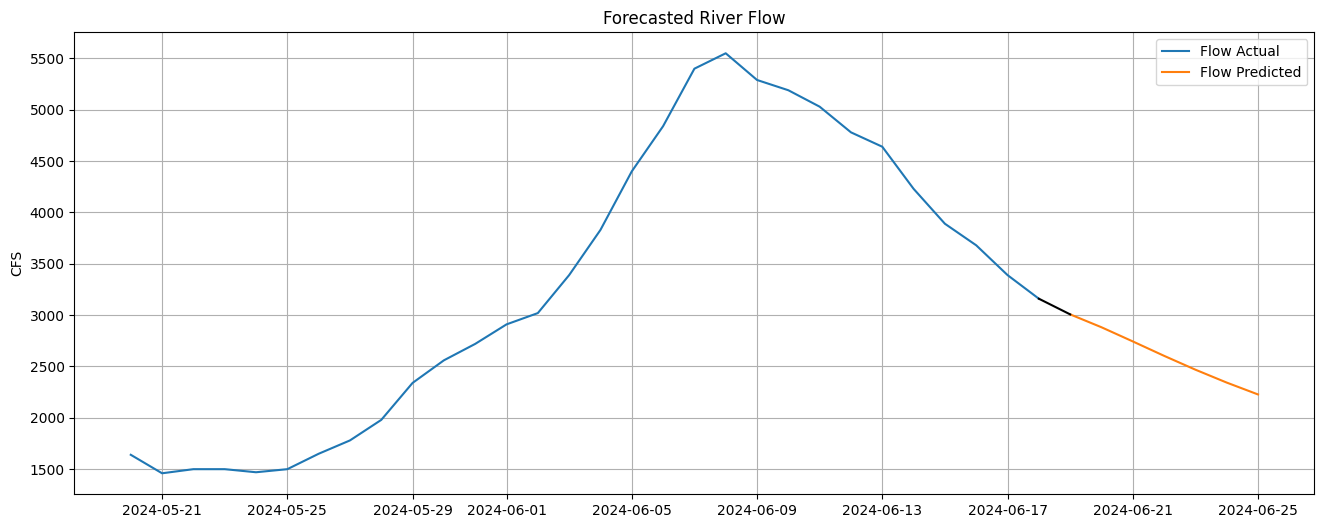

In [72]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Flow Actuals'][start:end], label='Flow Actual')
plt.plot(forecast_df['Flow Predicted'], label='Flow Predicted')
plt.plot([end, forecast_start], [post_processed_df['Flow Actuals'].iloc[-1], forecast_df['Flow Predicted'].iloc[0]], 'k-')
plt.ylabel('CFS')
plt.title('Forecasted River Flow')
plt.legend()
plt.grid()
plt.show()

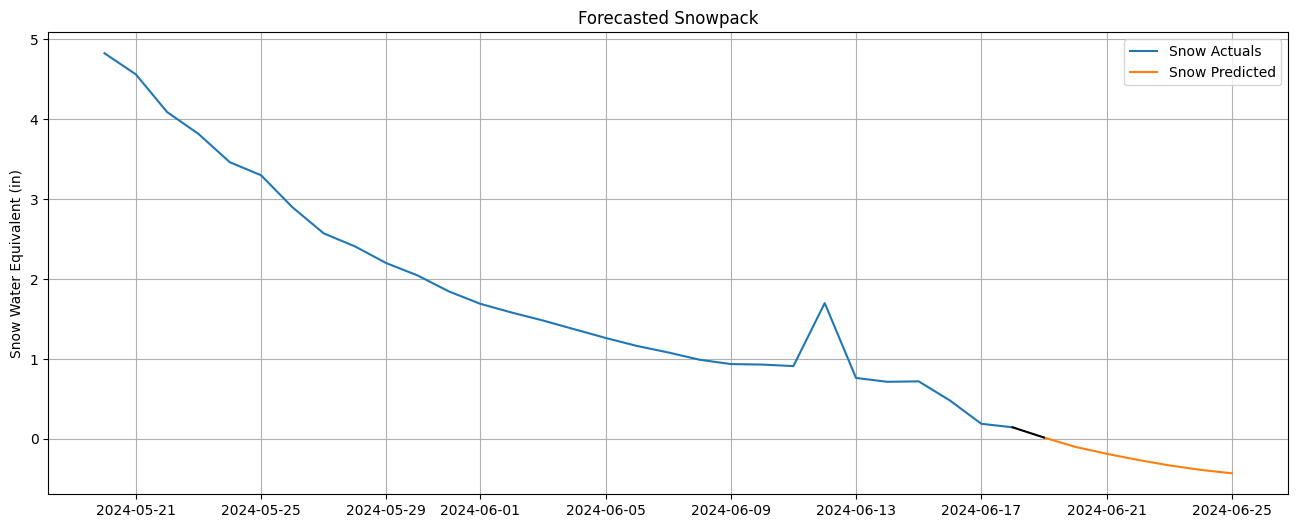

In [73]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Snow Actuals'][start:end], label='Snow Actuals')
plt.plot(forecast_df['Snow Predicted'], label='Snow Predicted')
plt.plot([end, forecast_start], [post_processed_df['Snow Actuals'].iloc[-1], forecast_df['Snow Predicted'].iloc[0]], 'k-')
plt.ylabel('Snow Water Equivalent (in)')
plt.title('Forecasted Snowpack')
plt.legend()
plt.grid()
plt.show()

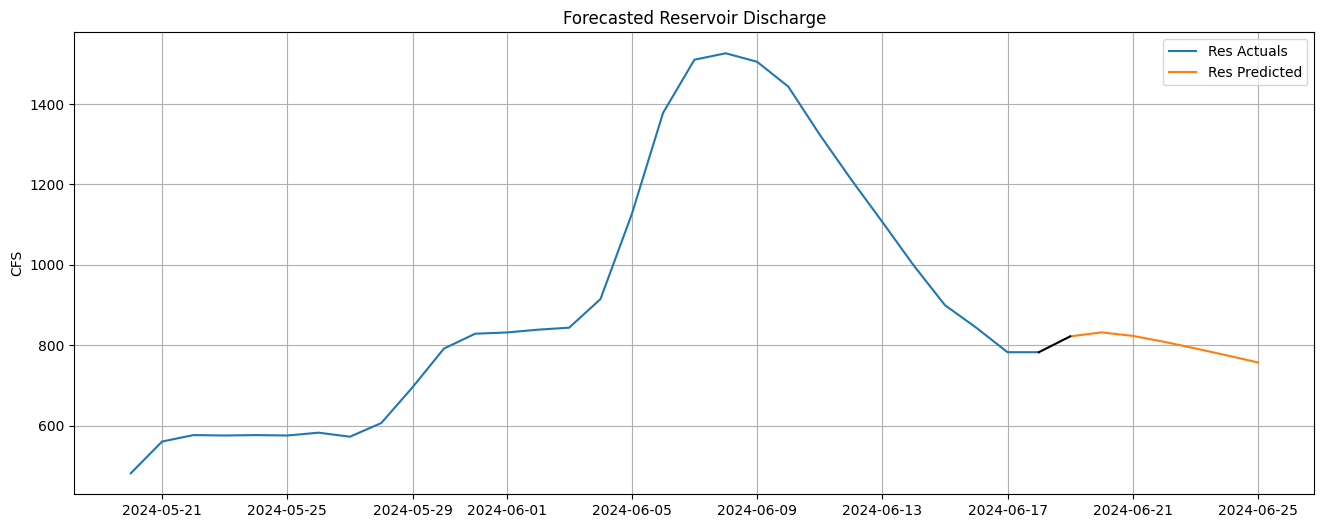

In [74]:
start, end = post_processed_df.index[-30], post_processed_df.index[-1]
plt.figure(figsize=(16, 6))
plt.plot(post_processed_df['Res Actuals'][start:end], label='Res Actuals')
plt.plot(forecast_df['Res Predicted'], label='Res Predicted')
plt.plot([end, forecast_start], [post_processed_df['Res Actuals'].iloc[-1], forecast_df['Res Predicted'].iloc[0]], 'k-')
plt.ylabel('CFS')
plt.title('Forecasted Reservoir Discharge')
plt.legend()
plt.grid()
plt.show()